# Tutorial 7: ARGA & ARVGA  

Paper:
* [Adversarially Regularized Graph Autoencoder for Graph Embedding](https://www.ijcai.org/Proceedings/2018/0362.pdf)  

Code:
 * [ARGA & ARVGA](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/autoencoder.html)
 * [Example on clustering](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/argva_node_clustering.py)

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 25.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [2]:
import os.path as osp
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.autoencoder import ARGVA
from torch_geometric.utils import train_test_split_edges

In [3]:
use_cuda = False

## Define the dataset

Download the dataset

In [4]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset.get(0)

Processing...
Done!


Get the number of nodes

In [5]:
num_nodes = data.x.shape[0]

Create the train/val/test data

In [6]:
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)
data

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[2708, 1433], y=[2708], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])

## Define the model

Define the encoder classes (the same as in `Tutorial 6`)

In [7]:
class VEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

Define the discriminator class

In [8]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

Define the training algorithm

In [9]:
def train():
    model.train()
    encoder_optimizer.zero_grad()

    z = model.encode(data.x, data.train_pos_edge_index)

    for i in range(5):
        idx = range(num_nodes)
        discriminator.train()
        discriminator_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z[idx]) # Comment
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()

    loss = 0
    loss = loss + model.reg_loss(z)  # Comment

    loss = loss + model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()

    encoder_optimizer.step()

    return loss

Define a training test method

In [10]:
@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    # Cluster embedded values using k-means.
    kmeans_input = z.cpu().numpy()
    kmeans = KMeans(n_clusters=7, random_state=0).fit(kmeans_input)
    pred = kmeans.predict(kmeans_input)

    labels = data.y.cpu().numpy()
    completeness = completeness_score(labels, pred)
    hm = homogeneity_score(labels, pred)
    nmi = v_measure_score(labels, pred)

    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

    return auc, ap, completeness, hm, nmi

## Initialize the model

Initialize an encoder and a discriminator

In [11]:
latent_size = 32
encoder = VEncoder(data.num_features, out_channels=latent_size)

discriminator = Discriminator(in_channels=latent_size, hidden_channels=64,
                              out_channels=1) # Comment

Initialize the model and move everything to the GPU

In [12]:
model = ARGVA(encoder, discriminator)

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
model, data = model.to(device), data.to(device)

Define the optimizers

In [13]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)

### Train the model

In [14]:
for epoch in range(1, 201):
    loss = train()
    auc, ap, completeness, hm, nmi = test()
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
           f'AP: {ap:.3f}, Completeness: {completeness:.3f}, '
           f'Homogeneity: {hm:.3f}, NMI: {nmi:.3f}'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 001, Loss: 5.329, AUC: 0.733, AP: 0.749, Completeness: 0.132, Homogeneity: 0.134, NMI: 0.133


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 002, Loss: 4.699, AUC: 0.704, AP: 0.729, Completeness: 0.108, Homogeneity: 0.107, NMI: 0.108


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 003, Loss: 4.170, AUC: 0.694, AP: 0.721, Completeness: 0.101, Homogeneity: 0.098, NMI: 0.100


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 004, Loss: 3.645, AUC: 0.695, AP: 0.721, Completeness: 0.113, Homogeneity: 0.109, NMI: 0.111


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 005, Loss: 3.228, AUC: 0.704, AP: 0.727, Completeness: 0.140, Homogeneity: 0.140, NMI: 0.140


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 006, Loss: 2.945, AUC: 0.719, AP: 0.738, Completeness: 0.159, Homogeneity: 0.159, NMI: 0.159


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 007, Loss: 2.643, AUC: 0.743, AP: 0.758, Completeness: 0.208, Homogeneity: 0.209, NMI: 0.209


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 008, Loss: 2.463, AUC: 0.769, AP: 0.781, Completeness: 0.241, Homogeneity: 0.241, NMI: 0.241


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 009, Loss: 2.251, AUC: 0.780, AP: 0.792, Completeness: 0.256, Homogeneity: 0.257, NMI: 0.256


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 010, Loss: 2.153, AUC: 0.778, AP: 0.791, Completeness: 0.298, Homogeneity: 0.295, NMI: 0.297


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 011, Loss: 2.112, AUC: 0.778, AP: 0.793, Completeness: 0.281, Homogeneity: 0.281, NMI: 0.281


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 012, Loss: 2.115, AUC: 0.780, AP: 0.799, Completeness: 0.323, Homogeneity: 0.321, NMI: 0.322


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 013, Loss: 2.172, AUC: 0.772, AP: 0.796, Completeness: 0.328, Homogeneity: 0.332, NMI: 0.330


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 014, Loss: 2.282, AUC: 0.763, AP: 0.789, Completeness: 0.324, Homogeneity: 0.333, NMI: 0.329


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 015, Loss: 2.432, AUC: 0.764, AP: 0.789, Completeness: 0.335, Homogeneity: 0.341, NMI: 0.338


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 016, Loss: 2.550, AUC: 0.779, AP: 0.798, Completeness: 0.354, Homogeneity: 0.360, NMI: 0.357


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 017, Loss: 2.610, AUC: 0.806, AP: 0.817, Completeness: 0.366, Homogeneity: 0.373, NMI: 0.369


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 018, Loss: 2.542, AUC: 0.828, AP: 0.832, Completeness: 0.413, Homogeneity: 0.384, NMI: 0.398


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 019, Loss: 2.449, AUC: 0.836, AP: 0.836, Completeness: 0.412, Homogeneity: 0.386, NMI: 0.398


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 020, Loss: 2.384, AUC: 0.836, AP: 0.837, Completeness: 0.423, Homogeneity: 0.410, NMI: 0.416


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 021, Loss: 2.428, AUC: 0.831, AP: 0.835, Completeness: 0.425, Homogeneity: 0.412, NMI: 0.418


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 022, Loss: 2.573, AUC: 0.827, AP: 0.832, Completeness: 0.425, Homogeneity: 0.413, NMI: 0.419


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 023, Loss: 2.820, AUC: 0.829, AP: 0.833, Completeness: 0.423, Homogeneity: 0.410, NMI: 0.416


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 024, Loss: 3.074, AUC: 0.837, AP: 0.839, Completeness: 0.426, Homogeneity: 0.414, NMI: 0.420


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 025, Loss: 3.211, AUC: 0.848, AP: 0.846, Completeness: 0.428, Homogeneity: 0.433, NMI: 0.431


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 026, Loss: 3.240, AUC: 0.854, AP: 0.850, Completeness: 0.435, Homogeneity: 0.423, NMI: 0.429


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 027, Loss: 3.226, AUC: 0.853, AP: 0.848, Completeness: 0.437, Homogeneity: 0.425, NMI: 0.431


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 028, Loss: 3.289, AUC: 0.847, AP: 0.843, Completeness: 0.436, Homogeneity: 0.425, NMI: 0.430


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 029, Loss: 3.430, AUC: 0.839, AP: 0.837, Completeness: 0.431, Homogeneity: 0.419, NMI: 0.425


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 030, Loss: 3.591, AUC: 0.834, AP: 0.834, Completeness: 0.425, Homogeneity: 0.437, NMI: 0.431


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 031, Loss: 3.717, AUC: 0.833, AP: 0.834, Completeness: 0.432, Homogeneity: 0.437, NMI: 0.434


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 032, Loss: 3.788, AUC: 0.837, AP: 0.838, Completeness: 0.431, Homogeneity: 0.434, NMI: 0.433


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 033, Loss: 3.828, AUC: 0.843, AP: 0.842, Completeness: 0.419, Homogeneity: 0.424, NMI: 0.421


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 034, Loss: 3.947, AUC: 0.848, AP: 0.844, Completeness: 0.414, Homogeneity: 0.417, NMI: 0.416


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 035, Loss: 4.066, AUC: 0.847, AP: 0.843, Completeness: 0.409, Homogeneity: 0.382, NMI: 0.395


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 036, Loss: 4.131, AUC: 0.846, AP: 0.840, Completeness: 0.387, Homogeneity: 0.382, NMI: 0.384


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 037, Loss: 4.169, AUC: 0.846, AP: 0.838, Completeness: 0.385, Homogeneity: 0.383, NMI: 0.384


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 038, Loss: 4.279, AUC: 0.847, AP: 0.837, Completeness: 0.385, Homogeneity: 0.384, NMI: 0.384


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 039, Loss: 4.308, AUC: 0.847, AP: 0.835, Completeness: 0.381, Homogeneity: 0.381, NMI: 0.381


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 040, Loss: 4.310, AUC: 0.848, AP: 0.835, Completeness: 0.378, Homogeneity: 0.377, NMI: 0.378


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 041, Loss: 4.287, AUC: 0.847, AP: 0.834, Completeness: 0.373, Homogeneity: 0.375, NMI: 0.374


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 042, Loss: 4.287, AUC: 0.846, AP: 0.834, Completeness: 0.376, Homogeneity: 0.378, NMI: 0.377


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 043, Loss: 4.333, AUC: 0.846, AP: 0.833, Completeness: 0.373, Homogeneity: 0.376, NMI: 0.374


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 044, Loss: 4.204, AUC: 0.845, AP: 0.833, Completeness: 0.377, Homogeneity: 0.379, NMI: 0.378


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 045, Loss: 4.031, AUC: 0.844, AP: 0.833, Completeness: 0.372, Homogeneity: 0.378, NMI: 0.375


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 046, Loss: 3.979, AUC: 0.843, AP: 0.832, Completeness: 0.365, Homogeneity: 0.373, NMI: 0.369


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 047, Loss: 3.914, AUC: 0.843, AP: 0.832, Completeness: 0.386, Homogeneity: 0.388, NMI: 0.387


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 048, Loss: 3.877, AUC: 0.844, AP: 0.833, Completeness: 0.383, Homogeneity: 0.388, NMI: 0.386


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 049, Loss: 3.822, AUC: 0.845, AP: 0.834, Completeness: 0.387, Homogeneity: 0.390, NMI: 0.389


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 050, Loss: 3.825, AUC: 0.845, AP: 0.833, Completeness: 0.386, Homogeneity: 0.391, NMI: 0.388


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 051, Loss: 3.788, AUC: 0.844, AP: 0.831, Completeness: 0.386, Homogeneity: 0.393, NMI: 0.390


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 052, Loss: 3.711, AUC: 0.845, AP: 0.831, Completeness: 0.387, Homogeneity: 0.394, NMI: 0.390


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 053, Loss: 3.739, AUC: 0.847, AP: 0.834, Completeness: 0.387, Homogeneity: 0.396, NMI: 0.392


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 054, Loss: 3.767, AUC: 0.849, AP: 0.839, Completeness: 0.413, Homogeneity: 0.403, NMI: 0.408


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 055, Loss: 3.756, AUC: 0.852, AP: 0.842, Completeness: 0.413, Homogeneity: 0.404, NMI: 0.408


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 056, Loss: 3.844, AUC: 0.854, AP: 0.845, Completeness: 0.417, Homogeneity: 0.408, NMI: 0.413


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 057, Loss: 3.890, AUC: 0.855, AP: 0.847, Completeness: 0.414, Homogeneity: 0.403, NMI: 0.408


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 058, Loss: 3.883, AUC: 0.857, AP: 0.849, Completeness: 0.417, Homogeneity: 0.407, NMI: 0.412


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 059, Loss: 3.943, AUC: 0.859, AP: 0.851, Completeness: 0.417, Homogeneity: 0.405, NMI: 0.411


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 060, Loss: 4.006, AUC: 0.860, AP: 0.852, Completeness: 0.418, Homogeneity: 0.406, NMI: 0.412


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 061, Loss: 4.035, AUC: 0.862, AP: 0.854, Completeness: 0.416, Homogeneity: 0.403, NMI: 0.409


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 062, Loss: 4.004, AUC: 0.863, AP: 0.856, Completeness: 0.420, Homogeneity: 0.408, NMI: 0.414


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 063, Loss: 4.052, AUC: 0.864, AP: 0.857, Completeness: 0.467, Homogeneity: 0.445, NMI: 0.456


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 064, Loss: 4.051, AUC: 0.865, AP: 0.858, Completeness: 0.478, Homogeneity: 0.450, NMI: 0.464


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 065, Loss: 4.049, AUC: 0.866, AP: 0.859, Completeness: 0.481, Homogeneity: 0.453, NMI: 0.467


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 066, Loss: 4.148, AUC: 0.867, AP: 0.860, Completeness: 0.482, Homogeneity: 0.454, NMI: 0.468


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 067, Loss: 4.021, AUC: 0.868, AP: 0.861, Completeness: 0.482, Homogeneity: 0.455, NMI: 0.468


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 068, Loss: 4.111, AUC: 0.869, AP: 0.863, Completeness: 0.482, Homogeneity: 0.455, NMI: 0.469


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 069, Loss: 4.074, AUC: 0.870, AP: 0.864, Completeness: 0.470, Homogeneity: 0.447, NMI: 0.458


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 070, Loss: 4.041, AUC: 0.871, AP: 0.865, Completeness: 0.470, Homogeneity: 0.448, NMI: 0.459


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 071, Loss: 4.109, AUC: 0.872, AP: 0.867, Completeness: 0.468, Homogeneity: 0.447, NMI: 0.457


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 072, Loss: 3.983, AUC: 0.873, AP: 0.868, Completeness: 0.471, Homogeneity: 0.449, NMI: 0.460


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 073, Loss: 4.069, AUC: 0.875, AP: 0.870, Completeness: 0.470, Homogeneity: 0.449, NMI: 0.459


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 074, Loss: 4.046, AUC: 0.876, AP: 0.872, Completeness: 0.473, Homogeneity: 0.452, NMI: 0.462


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 075, Loss: 4.070, AUC: 0.878, AP: 0.874, Completeness: 0.475, Homogeneity: 0.454, NMI: 0.465


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 076, Loss: 4.070, AUC: 0.879, AP: 0.876, Completeness: 0.482, Homogeneity: 0.461, NMI: 0.471


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 077, Loss: 4.040, AUC: 0.881, AP: 0.878, Completeness: 0.482, Homogeneity: 0.461, NMI: 0.472


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 078, Loss: 4.008, AUC: 0.882, AP: 0.880, Completeness: 0.483, Homogeneity: 0.464, NMI: 0.473


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 079, Loss: 3.940, AUC: 0.884, AP: 0.883, Completeness: 0.484, Homogeneity: 0.463, NMI: 0.474


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 080, Loss: 4.053, AUC: 0.886, AP: 0.885, Completeness: 0.478, Homogeneity: 0.462, NMI: 0.470


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 081, Loss: 3.956, AUC: 0.888, AP: 0.887, Completeness: 0.478, Homogeneity: 0.463, NMI: 0.470


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 082, Loss: 4.092, AUC: 0.889, AP: 0.889, Completeness: 0.478, Homogeneity: 0.464, NMI: 0.471


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 083, Loss: 3.996, AUC: 0.891, AP: 0.892, Completeness: 0.476, Homogeneity: 0.462, NMI: 0.469


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 084, Loss: 3.978, AUC: 0.892, AP: 0.893, Completeness: 0.477, Homogeneity: 0.463, NMI: 0.470


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 085, Loss: 4.042, AUC: 0.893, AP: 0.894, Completeness: 0.477, Homogeneity: 0.463, NMI: 0.470


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 086, Loss: 4.036, AUC: 0.894, AP: 0.895, Completeness: 0.468, Homogeneity: 0.458, NMI: 0.463


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 087, Loss: 4.071, AUC: 0.895, AP: 0.896, Completeness: 0.467, Homogeneity: 0.457, NMI: 0.462


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 088, Loss: 3.967, AUC: 0.896, AP: 0.897, Completeness: 0.531, Homogeneity: 0.473, NMI: 0.500


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 089, Loss: 3.905, AUC: 0.896, AP: 0.898, Completeness: 0.530, Homogeneity: 0.473, NMI: 0.500


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 090, Loss: 3.891, AUC: 0.897, AP: 0.898, Completeness: 0.530, Homogeneity: 0.473, NMI: 0.500


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 091, Loss: 3.897, AUC: 0.898, AP: 0.899, Completeness: 0.513, Homogeneity: 0.470, NMI: 0.491


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 092, Loss: 3.872, AUC: 0.899, AP: 0.900, Completeness: 0.543, Homogeneity: 0.529, NMI: 0.536


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 093, Loss: 3.860, AUC: 0.900, AP: 0.901, Completeness: 0.546, Homogeneity: 0.534, NMI: 0.540


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 094, Loss: 3.856, AUC: 0.901, AP: 0.902, Completeness: 0.542, Homogeneity: 0.532, NMI: 0.537


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 095, Loss: 3.864, AUC: 0.902, AP: 0.902, Completeness: 0.544, Homogeneity: 0.536, NMI: 0.540


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 096, Loss: 3.771, AUC: 0.902, AP: 0.903, Completeness: 0.541, Homogeneity: 0.534, NMI: 0.537


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 097, Loss: 3.805, AUC: 0.903, AP: 0.903, Completeness: 0.533, Homogeneity: 0.529, NMI: 0.531


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 098, Loss: 3.811, AUC: 0.903, AP: 0.903, Completeness: 0.525, Homogeneity: 0.523, NMI: 0.524


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 099, Loss: 3.867, AUC: 0.904, AP: 0.904, Completeness: 0.526, Homogeneity: 0.507, NMI: 0.516


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 100, Loss: 3.801, AUC: 0.905, AP: 0.905, Completeness: 0.513, Homogeneity: 0.509, NMI: 0.511


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 101, Loss: 3.780, AUC: 0.906, AP: 0.906, Completeness: 0.512, Homogeneity: 0.509, NMI: 0.510


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 102, Loss: 3.754, AUC: 0.907, AP: 0.907, Completeness: 0.514, Homogeneity: 0.510, NMI: 0.512


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 103, Loss: 3.818, AUC: 0.908, AP: 0.908, Completeness: 0.511, Homogeneity: 0.508, NMI: 0.510


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 104, Loss: 3.809, AUC: 0.910, AP: 0.909, Completeness: 0.504, Homogeneity: 0.503, NMI: 0.504


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 105, Loss: 3.815, AUC: 0.911, AP: 0.910, Completeness: 0.504, Homogeneity: 0.504, NMI: 0.504


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 106, Loss: 3.807, AUC: 0.911, AP: 0.911, Completeness: 0.507, Homogeneity: 0.509, NMI: 0.508


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 107, Loss: 3.710, AUC: 0.911, AP: 0.911, Completeness: 0.505, Homogeneity: 0.508, NMI: 0.506


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 108, Loss: 3.783, AUC: 0.910, AP: 0.911, Completeness: 0.509, Homogeneity: 0.510, NMI: 0.509


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 109, Loss: 3.790, AUC: 0.910, AP: 0.912, Completeness: 0.506, Homogeneity: 0.509, NMI: 0.508


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 110, Loss: 3.833, AUC: 0.911, AP: 0.912, Completeness: 0.505, Homogeneity: 0.507, NMI: 0.506


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 111, Loss: 3.755, AUC: 0.912, AP: 0.913, Completeness: 0.506, Homogeneity: 0.510, NMI: 0.508


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 112, Loss: 3.756, AUC: 0.913, AP: 0.914, Completeness: 0.503, Homogeneity: 0.508, NMI: 0.505


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 113, Loss: 3.812, AUC: 0.914, AP: 0.915, Completeness: 0.502, Homogeneity: 0.509, NMI: 0.505


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 114, Loss: 3.725, AUC: 0.915, AP: 0.917, Completeness: 0.503, Homogeneity: 0.509, NMI: 0.506


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 115, Loss: 3.791, AUC: 0.916, AP: 0.918, Completeness: 0.509, Homogeneity: 0.514, NMI: 0.512


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 116, Loss: 3.805, AUC: 0.918, AP: 0.919, Completeness: 0.506, Homogeneity: 0.511, NMI: 0.508


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 117, Loss: 3.784, AUC: 0.918, AP: 0.920, Completeness: 0.517, Homogeneity: 0.517, NMI: 0.517


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 118, Loss: 3.715, AUC: 0.919, AP: 0.920, Completeness: 0.507, Homogeneity: 0.514, NMI: 0.511


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 119, Loss: 3.691, AUC: 0.919, AP: 0.921, Completeness: 0.503, Homogeneity: 0.512, NMI: 0.508


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 120, Loss: 3.674, AUC: 0.919, AP: 0.921, Completeness: 0.500, Homogeneity: 0.508, NMI: 0.504


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 121, Loss: 3.721, AUC: 0.919, AP: 0.921, Completeness: 0.499, Homogeneity: 0.507, NMI: 0.503


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 122, Loss: 3.691, AUC: 0.919, AP: 0.921, Completeness: 0.495, Homogeneity: 0.504, NMI: 0.500


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 123, Loss: 3.665, AUC: 0.918, AP: 0.921, Completeness: 0.497, Homogeneity: 0.507, NMI: 0.502


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 124, Loss: 3.732, AUC: 0.918, AP: 0.921, Completeness: 0.490, Homogeneity: 0.501, NMI: 0.495


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 125, Loss: 3.631, AUC: 0.917, AP: 0.920, Completeness: 0.492, Homogeneity: 0.502, NMI: 0.497


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 126, Loss: 3.702, AUC: 0.918, AP: 0.920, Completeness: 0.494, Homogeneity: 0.503, NMI: 0.498


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 127, Loss: 3.700, AUC: 0.918, AP: 0.921, Completeness: 0.492, Homogeneity: 0.503, NMI: 0.497


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 128, Loss: 3.616, AUC: 0.919, AP: 0.921, Completeness: 0.498, Homogeneity: 0.508, NMI: 0.503


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 129, Loss: 3.679, AUC: 0.919, AP: 0.922, Completeness: 0.503, Homogeneity: 0.509, NMI: 0.506


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 130, Loss: 3.609, AUC: 0.919, AP: 0.922, Completeness: 0.471, Homogeneity: 0.479, NMI: 0.475


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 131, Loss: 3.659, AUC: 0.920, AP: 0.922, Completeness: 0.468, Homogeneity: 0.477, NMI: 0.473


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 132, Loss: 3.691, AUC: 0.920, AP: 0.923, Completeness: 0.483, Homogeneity: 0.492, NMI: 0.487


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 133, Loss: 3.635, AUC: 0.921, AP: 0.923, Completeness: 0.479, Homogeneity: 0.492, NMI: 0.485


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 134, Loss: 3.615, AUC: 0.921, AP: 0.923, Completeness: 0.453, Homogeneity: 0.463, NMI: 0.458


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 135, Loss: 3.605, AUC: 0.921, AP: 0.923, Completeness: 0.452, Homogeneity: 0.462, NMI: 0.457


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 136, Loss: 3.647, AUC: 0.920, AP: 0.923, Completeness: 0.451, Homogeneity: 0.461, NMI: 0.456


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 137, Loss: 3.605, AUC: 0.920, AP: 0.922, Completeness: 0.451, Homogeneity: 0.460, NMI: 0.455


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 138, Loss: 3.683, AUC: 0.920, AP: 0.922, Completeness: 0.461, Homogeneity: 0.469, NMI: 0.465


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 139, Loss: 3.652, AUC: 0.920, AP: 0.923, Completeness: 0.486, Homogeneity: 0.497, NMI: 0.491


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 140, Loss: 3.686, AUC: 0.921, AP: 0.923, Completeness: 0.486, Homogeneity: 0.498, NMI: 0.492


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 141, Loss: 3.522, AUC: 0.921, AP: 0.923, Completeness: 0.469, Homogeneity: 0.482, NMI: 0.476


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 142, Loss: 3.529, AUC: 0.921, AP: 0.923, Completeness: 0.471, Homogeneity: 0.484, NMI: 0.477


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 143, Loss: 3.560, AUC: 0.921, AP: 0.923, Completeness: 0.483, Homogeneity: 0.494, NMI: 0.488


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 144, Loss: 3.566, AUC: 0.921, AP: 0.923, Completeness: 0.464, Homogeneity: 0.476, NMI: 0.470


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 145, Loss: 3.530, AUC: 0.921, AP: 0.923, Completeness: 0.464, Homogeneity: 0.476, NMI: 0.470


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 146, Loss: 3.507, AUC: 0.921, AP: 0.923, Completeness: 0.468, Homogeneity: 0.478, NMI: 0.473


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 147, Loss: 3.548, AUC: 0.920, AP: 0.922, Completeness: 0.457, Homogeneity: 0.466, NMI: 0.461


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 148, Loss: 3.480, AUC: 0.919, AP: 0.922, Completeness: 0.465, Homogeneity: 0.472, NMI: 0.469


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 149, Loss: 3.499, AUC: 0.918, AP: 0.921, Completeness: 0.468, Homogeneity: 0.474, NMI: 0.471


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 150, Loss: 3.552, AUC: 0.917, AP: 0.921, Completeness: 0.481, Homogeneity: 0.485, NMI: 0.483


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 151, Loss: 3.538, AUC: 0.916, AP: 0.920, Completeness: 0.481, Homogeneity: 0.486, NMI: 0.483


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 152, Loss: 3.559, AUC: 0.915, AP: 0.919, Completeness: 0.481, Homogeneity: 0.486, NMI: 0.484


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 153, Loss: 3.437, AUC: 0.914, AP: 0.918, Completeness: 0.485, Homogeneity: 0.490, NMI: 0.488


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 154, Loss: 3.519, AUC: 0.912, AP: 0.917, Completeness: 0.457, Homogeneity: 0.478, NMI: 0.467


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 155, Loss: 3.535, AUC: 0.912, AP: 0.917, Completeness: 0.433, Homogeneity: 0.456, NMI: 0.444


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 156, Loss: 3.488, AUC: 0.911, AP: 0.917, Completeness: 0.447, Homogeneity: 0.472, NMI: 0.459


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 157, Loss: 3.435, AUC: 0.911, AP: 0.917, Completeness: 0.445, Homogeneity: 0.469, NMI: 0.457


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 158, Loss: 3.523, AUC: 0.911, AP: 0.918, Completeness: 0.447, Homogeneity: 0.470, NMI: 0.458


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 159, Loss: 3.446, AUC: 0.911, AP: 0.918, Completeness: 0.435, Homogeneity: 0.457, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 160, Loss: 3.492, AUC: 0.911, AP: 0.919, Completeness: 0.430, Homogeneity: 0.447, NMI: 0.438


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 161, Loss: 3.472, AUC: 0.912, AP: 0.919, Completeness: 0.436, Homogeneity: 0.454, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 162, Loss: 3.536, AUC: 0.912, AP: 0.920, Completeness: 0.433, Homogeneity: 0.449, NMI: 0.441


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 163, Loss: 3.442, AUC: 0.912, AP: 0.920, Completeness: 0.461, Homogeneity: 0.485, NMI: 0.472


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 164, Loss: 3.439, AUC: 0.912, AP: 0.919, Completeness: 0.474, Homogeneity: 0.491, NMI: 0.482


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 165, Loss: 3.409, AUC: 0.912, AP: 0.919, Completeness: 0.420, Homogeneity: 0.426, NMI: 0.423


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 166, Loss: 3.438, AUC: 0.912, AP: 0.918, Completeness: 0.417, Homogeneity: 0.430, NMI: 0.424


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 167, Loss: 3.469, AUC: 0.911, AP: 0.917, Completeness: 0.442, Homogeneity: 0.448, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 168, Loss: 3.436, AUC: 0.910, AP: 0.916, Completeness: 0.430, Homogeneity: 0.436, NMI: 0.433


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 169, Loss: 3.495, AUC: 0.909, AP: 0.915, Completeness: 0.424, Homogeneity: 0.432, NMI: 0.428


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 170, Loss: 3.402, AUC: 0.909, AP: 0.915, Completeness: 0.423, Homogeneity: 0.434, NMI: 0.428


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 171, Loss: 3.480, AUC: 0.908, AP: 0.914, Completeness: 0.459, Homogeneity: 0.460, NMI: 0.459


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 172, Loss: 3.466, AUC: 0.908, AP: 0.914, Completeness: 0.414, Homogeneity: 0.407, NMI: 0.410


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 173, Loss: 3.479, AUC: 0.908, AP: 0.914, Completeness: 0.418, Homogeneity: 0.424, NMI: 0.421


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 174, Loss: 3.454, AUC: 0.908, AP: 0.914, Completeness: 0.389, Homogeneity: 0.386, NMI: 0.387


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 175, Loss: 3.509, AUC: 0.908, AP: 0.915, Completeness: 0.402, Homogeneity: 0.404, NMI: 0.403


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 176, Loss: 3.473, AUC: 0.908, AP: 0.915, Completeness: 0.405, Homogeneity: 0.410, NMI: 0.407


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 177, Loss: 3.489, AUC: 0.908, AP: 0.915, Completeness: 0.406, Homogeneity: 0.409, NMI: 0.408


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 178, Loss: 3.426, AUC: 0.908, AP: 0.915, Completeness: 0.405, Homogeneity: 0.409, NMI: 0.407


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 179, Loss: 3.436, AUC: 0.908, AP: 0.915, Completeness: 0.410, Homogeneity: 0.401, NMI: 0.405


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 180, Loss: 3.404, AUC: 0.907, AP: 0.914, Completeness: 0.436, Homogeneity: 0.428, NMI: 0.432


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 181, Loss: 3.469, AUC: 0.907, AP: 0.913, Completeness: 0.418, Homogeneity: 0.419, NMI: 0.418


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 182, Loss: 3.420, AUC: 0.906, AP: 0.913, Completeness: 0.418, Homogeneity: 0.430, NMI: 0.424


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 183, Loss: 3.447, AUC: 0.905, AP: 0.912, Completeness: 0.418, Homogeneity: 0.420, NMI: 0.419


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 184, Loss: 3.422, AUC: 0.905, AP: 0.911, Completeness: 0.407, Homogeneity: 0.418, NMI: 0.413


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 185, Loss: 3.419, AUC: 0.905, AP: 0.911, Completeness: 0.448, Homogeneity: 0.457, NMI: 0.453


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 186, Loss: 3.388, AUC: 0.905, AP: 0.911, Completeness: 0.432, Homogeneity: 0.447, NMI: 0.439


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 187, Loss: 3.395, AUC: 0.905, AP: 0.911, Completeness: 0.400, Homogeneity: 0.412, NMI: 0.406


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 188, Loss: 3.424, AUC: 0.905, AP: 0.912, Completeness: 0.422, Homogeneity: 0.440, NMI: 0.431


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 189, Loss: 3.401, AUC: 0.906, AP: 0.912, Completeness: 0.427, Homogeneity: 0.439, NMI: 0.433


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 190, Loss: 3.356, AUC: 0.907, AP: 0.913, Completeness: 0.436, Homogeneity: 0.443, NMI: 0.440


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 191, Loss: 3.319, AUC: 0.908, AP: 0.913, Completeness: 0.437, Homogeneity: 0.448, NMI: 0.443


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 192, Loss: 3.371, AUC: 0.909, AP: 0.913, Completeness: 0.440, Homogeneity: 0.450, NMI: 0.445


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 193, Loss: 3.398, AUC: 0.909, AP: 0.914, Completeness: 0.447, Homogeneity: 0.454, NMI: 0.450


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 194, Loss: 3.345, AUC: 0.909, AP: 0.914, Completeness: 0.460, Homogeneity: 0.463, NMI: 0.462


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 195, Loss: 3.338, AUC: 0.909, AP: 0.914, Completeness: 0.435, Homogeneity: 0.448, NMI: 0.442


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 196, Loss: 3.388, AUC: 0.909, AP: 0.915, Completeness: 0.443, Homogeneity: 0.450, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 197, Loss: 3.344, AUC: 0.909, AP: 0.915, Completeness: 0.463, Homogeneity: 0.454, NMI: 0.458


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 198, Loss: 3.279, AUC: 0.910, AP: 0.916, Completeness: 0.439, Homogeneity: 0.453, NMI: 0.446


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 199, Loss: 3.355, AUC: 0.910, AP: 0.916, Completeness: 0.472, Homogeneity: 0.476, NMI: 0.474


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Epoch: 200, Loss: 3.280, AUC: 0.911, AP: 0.916, Completeness: 0.491, Homogeneity: 0.482, NMI: 0.486


In [15]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(1, figsize=(8, 8))
    fig.clf()
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

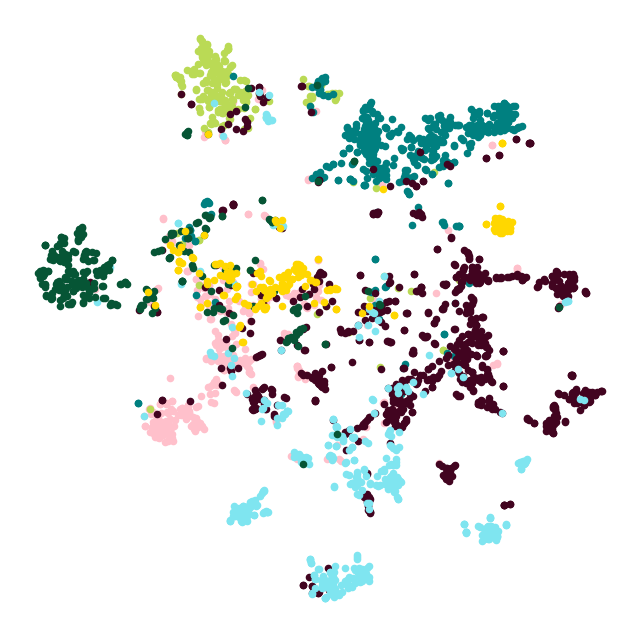

In [16]:
#%%
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)